# B-splines FEM solver for Poisson equation (2D)


In this section, we show hoa to use **simplines** to solve a 2D Poisson problem with homogeneous boundary conditions
$$
- \nabla^2 u = f, \Omega,
\\
u = 0, \partial \Omega
$$
where the computation domain $\Omega$ is the unit square.

In [1]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like, asarray
from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from simplines import SplineSpace
from simplines import TensorSpace
from simplines import StencilMatrix
from simplines import StencilVector

In [3]:
from gallery_section_04 import assemble_stiffness_2d
from gallery_section_04 import assemble_vector_2d

### Create the Finite Elements Space

In 2D, our Spline function space is defined as

$$
\mathcal{V}_h := \texttt{span}\{ B_{i_1}^{p_1} B_{i_2}^{p_1}, ~ 1 \le i_1 \le n_1, ~ 1 \le i_2 \le n_2\}
$$

which is basicaly 
$$
\mathcal{V}_h = \mathcal{V}_h^1 \otimes \mathcal{V}_h^2 
$$
where
$$
\mathcal{V}_h^1 := \texttt{span}\{ B_{i_1}^{p_1}, ~ 1 \le i_1 \le n_1\}
$$
and
$$
\mathcal{V}_h^2 := \texttt{span}\{ B_{i_2}^{p_2}, ~ 1 \le i_2 \le n_2\}
$$


In [4]:
# create the spline space for each direction
V1 = SplineSpace(degree=2, nelements=4)
V2 = SplineSpace(degree=2, nelements=4)

In [5]:
# create the tensor space
V = TensorSpace(V1, V2)

### Assemble the Stiffness Matrix

The stiffness matrix entries are defined as

$$
M_{\textbf{i}, \textbf{j}} := \int_{\Omega} \nabla B_{\textbf{i}} \cdot \nabla B_{\textbf{j}}
$$

where 
$$
B_{\textbf{i}}(x_1,x_2) := B_{i_1}(x_1)B_{i_2}(x_2), \quad \textbf{i} := (i_1,i_2) 
$$
and
$$
B_{\textbf{j}}(x_1,x_2) := B_{j_1}(x_1)B_{j_2}(x_2), \quad \textbf{j} := (j_1,j_2)
$$

In [6]:
stiffness = StencilMatrix(V.vector_space, V.vector_space)
stiffness = assemble_stiffness_2d( V.nelements, 
                                   V.degree, 
                                   V.spans, 
                                   V.basis, 
                                   V.weights, 
                                   V.points, 
                                   matrix=stiffness )

### Assemble the rhs

The right hand side entries are defined as

$$
F_{\textbf{i}} := \int_{\Omega} f B_{\textbf{i}} ~d\Omega
$$

In [7]:
rhs = StencilVector(V.vector_space)

f = lambda x,y: 2*x*(1 - x) + 2*y*(1 - y) 
rhs = assemble_vector_2d( f, 
                          V.nelements, 
                          V.degree, 
                          V.spans, 
                          V.basis, 
                          V.weights, 
                          V.points, 
                          rhs=rhs )

### Imposing boundary conditions

In [8]:
n1,n2 = V.nbasis

# ... resetting bnd dof to 0
stiffness[0,:,:,:] = 0.
stiffness[n1-1,:,:,:] = 0.
stiffness[:,0,:,:] = 0.
stiffness[:,n2-1,:,:] = 0.
# ...

# boundary x = 0
stiffness[0,:,0,:] = 1.

# boundary x = 1
stiffness[n1-1,:,0,:] = 1.

# boundary y = 0
stiffness[:,0,:,0] = 1.

# boundary y = 1
stiffness[:,n2-1,:,0] = 1.

# ...
rhs[0,:] = 0.
rhs[n1-1,:] = 0.
rhs[:,0] = 0.
rhs[:,n2-1] = 0.
# ...

From now on, you can use the function **apply_dirichlet** to set the dirichlet boundary conditions for both the matrix and rhs.

In [9]:
# convert the stencil matrix to scipy sparse
stiffness = stiffness.tosparse() 

In [10]:
# convert the stencil vector to a nd_array
rhs = rhs.toarray()

In [11]:
from scipy.sparse import csc_matrix, linalg as sla

lu = sla.splu(csc_matrix(stiffness))
x = lu.solve(rhs)

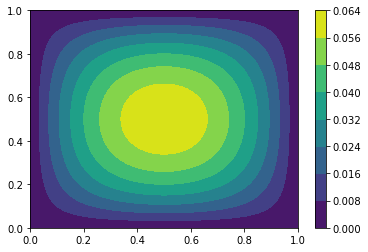

In [12]:
from simplines import plot_field_2d

u = x.reshape(V.nbasis)
plot_field_2d(V.knots, V.degree, u) ; plt.colorbar()